<a href="https://colab.research.google.com/github/AlgorithmBurv/PML/blob/main/PML_9_NLP_BBC_ImamMulyana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Dataset PML/bbc-text.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
df.isnull().sum()

category    0
text        0
dtype: int64

In [6]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


# NLTK

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
import string
from nltk.corpus import stopwords

In [9]:
def clean_text(text):

    stop_words = [stopwords.words("english")]
    no_punc = [word for word in text if word not in string.punctuation]
    no_punc_str = "".join(no_punc)
    return "".join([word for word in no_punc_str if word.lower() not in stop_words])

In [10]:
df["text_Cleaned"] = df["text"].apply(clean_text)

# Melakukan one hot encoding

In [11]:
sub = pd.get_dummies(df.category)
df_baru = pd.concat([df, sub], axis=1)
df_baru = df_baru.drop(columns=['category','text'])
df_baru

,text_Cleaned,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy exchatshow h...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


# Konversi data frame ke numpy array

In [12]:
text_Cleaned = df_baru['text_Cleaned'].values
label = df_baru[['business', 'entertainment', 'politics','sport','tech']].values

In [13]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_Cleaned   2225 non-null   object
 1   business       2225 non-null   uint8 
 2   entertainment  2225 non-null   uint8 
 3   politics       2225 non-null   uint8 
 4   sport          2225 non-null   uint8 
 5   tech           2225 non-null   uint8 
dtypes: object(1), uint8(5)
memory usage: 28.4+ KB


# Membagi data

In [14]:
from sklearn.model_selection import train_test_split
text_latih, text_test, label_latih, label_test = train_test_split(text_Cleaned, label, test_size=0.2)

# Melakukan tokenizer dan pad_sequence

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=6000, oov_token='x')
tokenizer.fit_on_texts(text_latih)
# tokenizer.fit_on_texts(text_test)

sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_test = tokenizer.texts_to_sequences(text_test)

padded_latih = pad_sequences(sekuens_latih, padding='post', maxlen=100, truncating='post')
padded_test = pad_sequences(sekuens_test, padding='post', maxlen=100, truncating='post')

# Membuat arsitektur model

In [16]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(6000, 16, input_length=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Membuat Callback

In [17]:
from tensorflow.keras.callbacks import Callback

class AccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
            print("\nAkurasi dan validasi melebihi 90%, menghentikan pelatihan.")
            self.model.stop_training = True

accuracy_callback = AccuracyCallback()

# Melatih model

In [18]:

history = model.fit(padded_latih,
                    label_latih,
                    epochs= 30,
                    validation_data=(padded_test, label_test),
                    verbose=2,
                    callbacks=[accuracy_callback]
                    )

Epoch 1/30
56/56 - 21s - loss: 1.6012 - accuracy: 0.2146 - val_loss: 1.5765 - val_accuracy: 0.2899 - 21s/epoch - 384ms/step
Epoch 2/30
56/56 - 6s - loss: 1.2524 - accuracy: 0.4315 - val_loss: 0.9514 - val_accuracy: 0.5213 - 6s/epoch - 104ms/step
Epoch 3/30
56/56 - 3s - loss: 0.7044 - accuracy: 0.7056 - val_loss: 0.6414 - val_accuracy: 0.7798 - 3s/epoch - 60ms/step
Epoch 4/30
56/56 - 2s - loss: 0.2885 - accuracy: 0.9140 - val_loss: 0.4351 - val_accuracy: 0.8742 - 2s/epoch - 41ms/step
Epoch 5/30
56/56 - 2s - loss: 0.0829 - accuracy: 0.9775 - val_loss: 0.3961 - val_accuracy: 0.8854 - 2s/epoch - 30ms/step
Epoch 6/30
56/56 - 1s - loss: 0.0417 - accuracy: 0.9876 - val_loss: 0.4677 - val_accuracy: 0.8742 - 1s/epoch - 23ms/step
Epoch 7/30
56/56 - 2s - loss: 0.1058 - accuracy: 0.9685 - val_loss: 0.4914 - val_accuracy: 0.8382 - 2s/epoch - 27ms/step
Epoch 8/30
56/56 - 2s - loss: 0.1248 - accuracy: 0.9601 - val_loss: 0.3461 - val_accuracy: 0.8966 - 2s/epoch - 35ms/step
Epoch 9/30

Akurasi dan vali

# Evaluasi Model

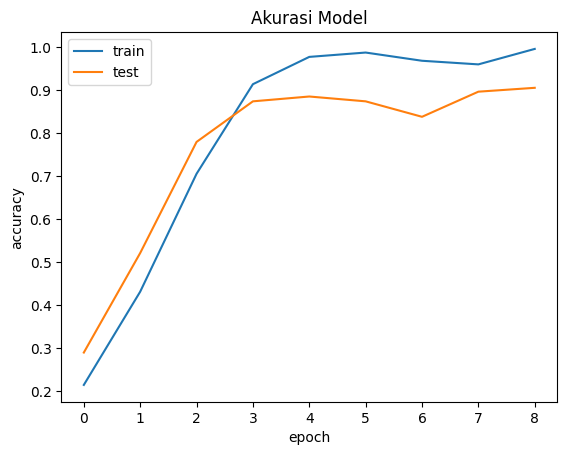

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

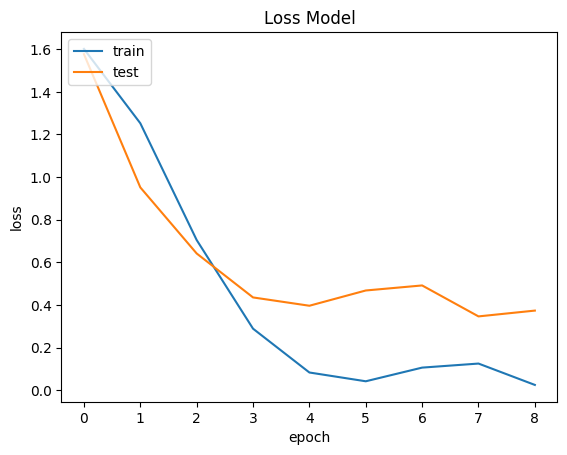

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()